# Task 2: Clustering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

## Loading the Customer Profile model

In [207]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

I        Iu      Imax         E      Savg    R         F  \
CustomerID                                                                    
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935   40  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438   76  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623   19  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  311  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080   73  1.845098   
...              ...       ...       ...       ...       ...  ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  160  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519    4  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  216  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421   10  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054    0  1.845098   

                   M  
CustomerID            
12347.0     3.556087  
12348.0     2.894560  
12349.0     3.163623  
12350.0     2.468938  
12352.0     3.102231  
...              ...  
18280.0     2.256718  
18281.0     1.907519  
18282.0     2.246991  
18283.0     3.309541  
18287.0     3.264175  

[4206 rows x 8 columns]

In [208]:
customer_profile.drop('R', axis=1, inplace=True)

## Standardization \& Dimensionality Reduction

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

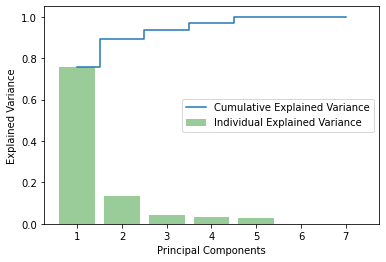

In [210]:
scaler = StandardScaler()
std_customer_profile = scaler.fit_transform(customer_profile)

pca = PCA()
pca.fit(std_customer_profile)

plt.step(range(1, customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, customer_profile.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='center right');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.

In [211]:
pca = PCA(n_components=2)
pca_customer_profile = pca.fit_transform(std_customer_profile)

## K-Means

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [212]:
def plot_silhouette_score(df, labels):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(df, labels)

    y_ax_lower, y_ax_upper = 0, 0
    y_tick = []

    for i, c in enumerate(cluster_labels):
    
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
    
        print('Cluster', c, 'avg silhouette:', np.mean(c_silhouette_vals))
    
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_tick.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    print('Total avg silhouette:', silhouette_avg)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.yticks=(y_tick, cluster_labels + 1)
    plt.ylabel('Points')
    plt.xlabel('Silhouette')
    plt.tight_layout()

In [225]:
def plot_similarity_heatmap(df, labels):
    df = pd.DataFrame(X)
    df['cluster'] = labels
    columns = df.columns[1:-1]
    df.sort_values(by='cluster', ascending=False, inplace=True)
    dist = euclidean_distances(df.loc[:, columns], df.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(sim, ax=ax)

In [226]:
def plot_basic_statistics(df, labels):
    df = pd.DataFrame(X)
    df['cluster'] = labels
    columns = df.columns[1:-1]
    means = []
    std = []
    for i in np.unique(df['cluster'].array):
        clust = df.loc[df['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)
    legend = []
    for i in np.unique(df['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns)

In [241]:
elbow = dict()
silhouette = dict()
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_customer_profile)
    elbow[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(pca_customer_profile, clusters)

The elbow method only uses intra-cluster distances while the silhouette method uses a combination of inter- and intra-cluster distances. So, we can expect that they end up with different results.

### Silhouette method

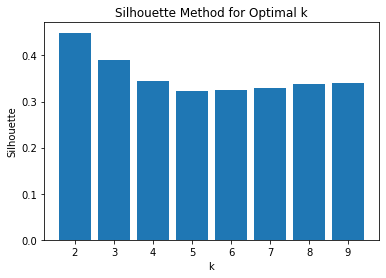

In [246]:
plt.bar(silhouette.keys(), silhouette.values())
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [231]:
print('The best silhouette score is:', max(silhouette.values()))

The best silhouette score is: 0.4494015465770799


In [232]:
kmeans = KMeans(init='k-means++', n_clusters=2)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

Cluster 0 avg silhouette: 0.4128421007675167
Cluster 1 avg silhouette: 0.4791218546791644
Total avg silhouette: 0.4494015465770799


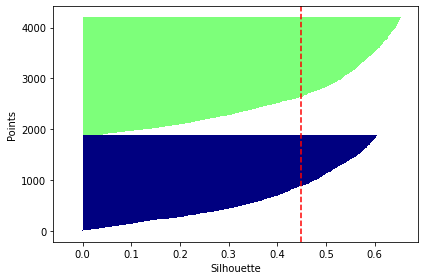

In [216]:
plot_silhouette_score(pca_customer_profile, clusters_customers)

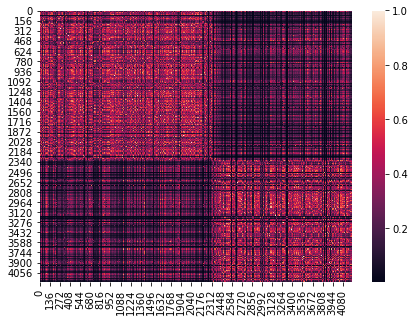

In [217]:
plot_similarity_heatmap(customer_profile, clusters_customers)

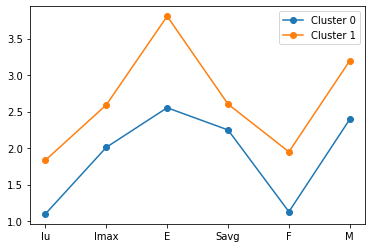

In [218]:
plot_basic_statistics(customer_profile, clusters_customers)

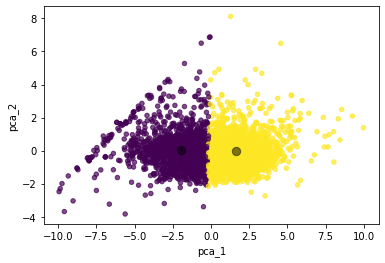

In [219]:
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [192]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0     1
CustomersNb  1886  2320

For comparison, if we run the K-Means algorithm without the PCA step, the result would be the following:

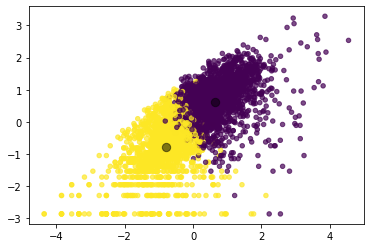

In [159]:
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

### Elbow method

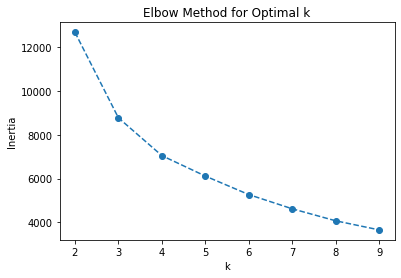

In [261]:
plt.plot(*zip(*elbow.items()), marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.ylabel('Inertia')
plt.xlabel('k');

In [250]:
print('The silhouette score for k = 3 is:', silhouette[3])

The silhouette score for k = 3 is: 0.3905313059889505


In [221]:
kmeans = KMeans(init='k-means++', n_clusters=3)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

Cluster 0 avg silhouette: 0.3511883517615114
Cluster 1 avg silhouette: 0.39591218325694183
Cluster 2 avg silhouette: 0.4070156659598673
Total avg silhouette: 0.3914096111931642


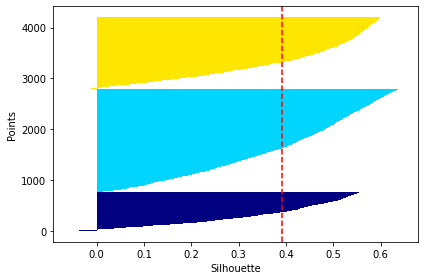

In [222]:
plot_silhouette_score(pca_customer_profile, clusters_customers)

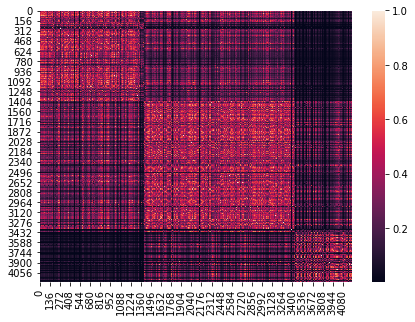

In [223]:
plot_similarity_heatmap(customer_profile, clusters_customers)

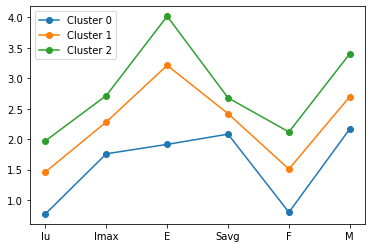

In [224]:
plot_basic_statistics(customer_profile, clusters_customers)

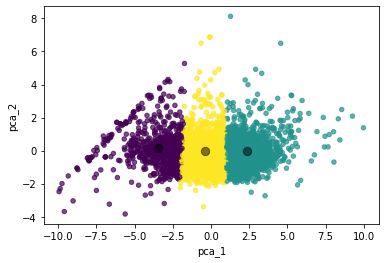

In [166]:
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7)
plt.xlabel('pca_1')
plt.ylabel('pca_2')
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [167]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0     1     2
CustomersNb  771  1421  2014

For comparison, if we run the K-Means algorithm without the PCA step, the result would be the following:

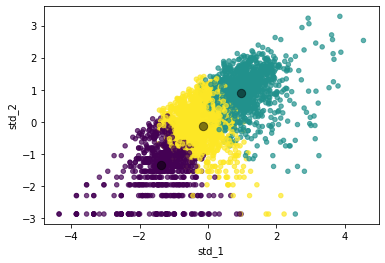

In [168]:
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
plt.xlabel('std_1')
plt.ylabel('std_2')
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [36]:
customer_profile_kmeans = customer_profile.copy(deep=True)
customer_profile_kmeans['cluster'] = clusters_customers
customer_profile_kmeans['cluster'] = customer_profile_kmeans['cluster'].map({0: 'high', 1: 'medium', 2: 'low'}) # check clusters-labels mapping for each run!
customer_profile_kmeans

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M cluster  
CustomerID                    
12347.0     3.556087    high  
12348.0     2.894560  medium  
12349.0     3.163623    high  
12350.0     2.468938  medium  
12352.0     3.102231  medium  
...              ...     ...  
18280.0     2.256718     low  
18281.0     1.907519     low  
18282.0     2.246991     low  
18283.0     3.309541    high  
18287.0     3.264175    high  

[4206 rows x 8 columns]

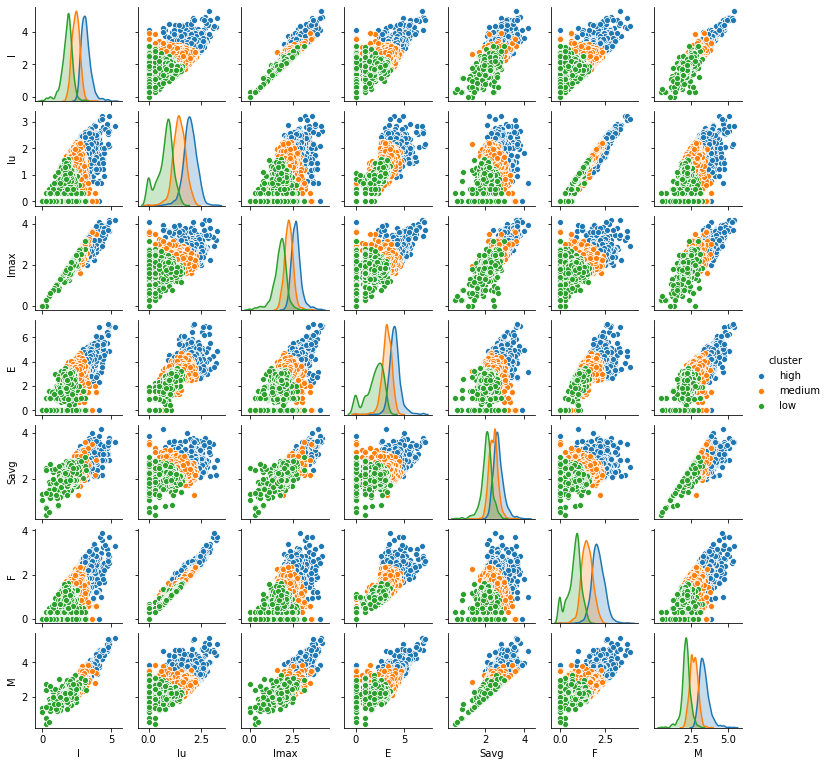

In [37]:
sns.pairplot(customer_profile_kmeans, hue='cluster', diag_kind='kde', height=1.5);

In [38]:
customer_profile_kmeans.to_csv('../dataset/customer_profile_kmeans.csv', sep='\t')

## Fuzzy C-Means

In [263]:
from fcmeans import FCM

In [264]:
fcmeans = FCM(n_clusters=3)
fcmeans.fit(pca_customer_profile)
clusters_customers = fcmeans.u.argmax(axis=1)

Cluster 0 avg silhouette: 0.39439923762174584
Cluster 1 avg silhouette: 0.40126260437106065
Cluster 2 avg silhouette: 0.32436500988367284
Total avg silhouette: 0.38238769059144145


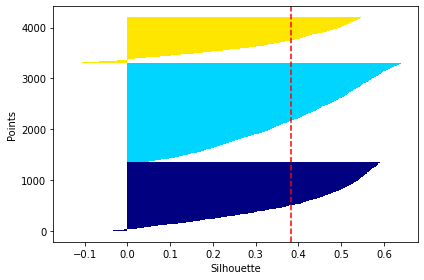

In [265]:
plot_silhouette_score(pca_customer_profile, clusters_customers)

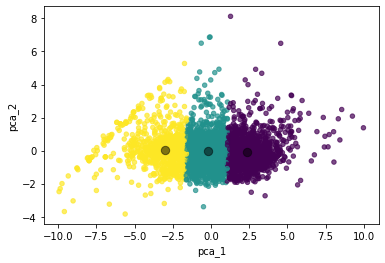

In [266]:
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7)
plt.xlabel('pca_1')
plt.ylabel('pca_2')
# select cluster centers
centroids = fcmeans.centers
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [267]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0     1    2
CustomersNb  1360  1935  911

For comparison, if we run the K-Means algorithm without the PCA step, the result would be the following:

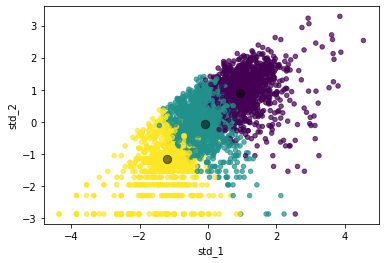

In [268]:
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
plt.xlabel('std_1')
plt.ylabel('std_2')
# select cluster centers
centroids = pca.inverse_transform(fcmeans.centers)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [272]:
customer_profile_fcmeans = customer_profile.copy(deep=True)
customer_profile_fcmeans['cluster'] = clusters_customers
customer_profile_fcmeans['cluster'] = customer_profile_fcmeans['cluster'].map({0: 'high', 1: 'medium', 2: 'low'}) # check clusters-labels mapping for each run!
customer_profile_fcmeans

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M cluster  
CustomerID                    
12347.0     3.556087    high  
12348.0     2.894560  medium  
12349.0     3.163623    high  
12350.0     2.468938  medium  
12352.0     3.102231  medium  
...              ...     ...  
18280.0     2.256718     low  
18281.0     1.907519     low  
18282.0     2.246991     low  
18283.0     3.309541    high  
18287.0     3.264175    high  

[4206 rows x 8 columns]

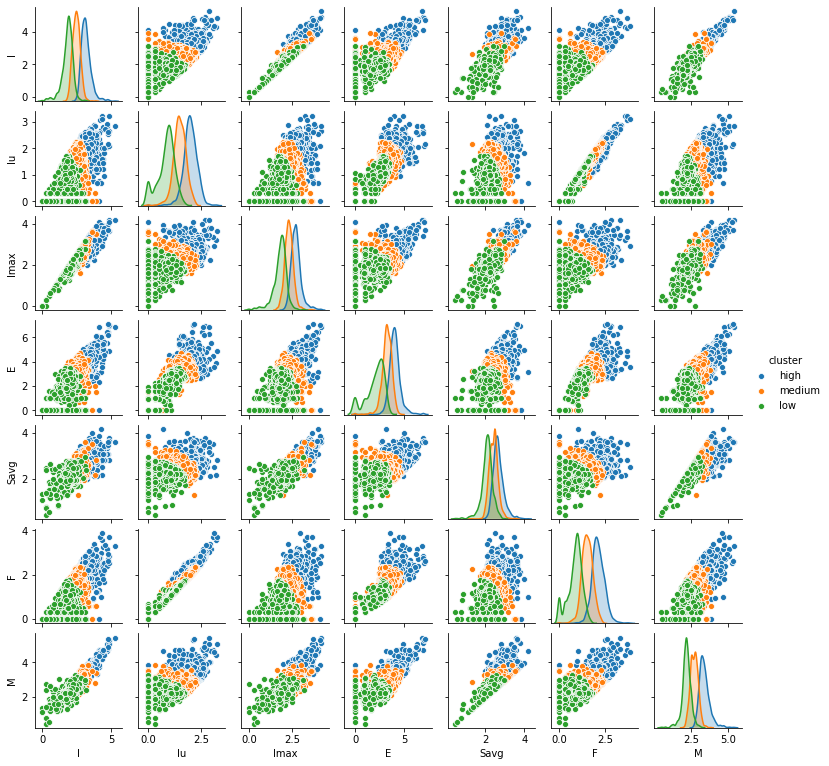

In [273]:
sns.pairplot(customer_profile_fcmeans, hue='cluster', diag_kind='kde', height=1.5);

In [274]:
customer_profile_fcmeans.to_csv('../dataset/customer_profile_fcmeans.csv', sep='\t')

## DBSCAN

We must provide a value for *eps* which defines the maximum distance between two points. Layman [[1]](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) describes an approach for automatically determining the optimal value for *eps*.


In Layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as *esp*.


We can calculate the distance from each point to its closest neighbour using the K-nearest neighbors. The point itself is included in *n_neighbors*. The Knn method returns two arrays, one which contains the distance to the closest *n_neighbors* points and the other which contains the index for each of those points. The optimal value for *eps* will be found at the point of maximum curvature.

In [74]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

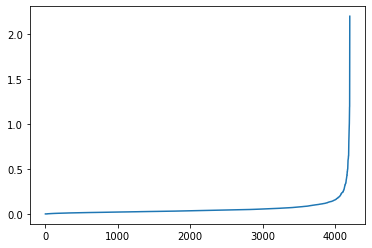

In [132]:
knn = NearestNeighbors(n_neighbors=20)
nbrs = knn.fit(pca_customer_profile)
distances, indices = nbrs.kneighbors(pca_customer_profile)
distances = np.sort(distances, axis=0)[:,1]
plt.plot(distances);

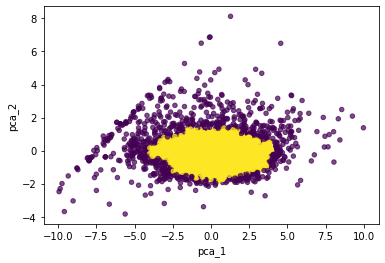

In [137]:
dbscan = DBSCAN(eps=0.25, min_samples=20)
clusters_customers = dbscan.fit_predict(pca_customer_profile)
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [138]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

-1     0
CustomersNb  810  3396

For comparison, if we run the DBSCAN algorithm without the PCA step, the result would be the following:

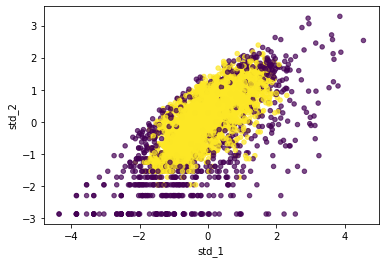

In [91]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [92]:
customer_profile_dbscan = customer_profile.copy(deep=True)
customer_profile_dbscan['cluster'] = clusters_customers
customer_profile_dbscan['cluster'] = customer_profile_dbscan['cluster']
customer_profile_dbscan

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M  cluster  
CustomerID                     
12347.0     3.556087        0  
12348.0     2.894560       -1  
12349.0     3.163623       -1  
12350.0     2.468938        0  
12352.0     3.102231        0  
...              ...      ...  
18280.0     2.256718        0  
18281.0     1.907519        0  
18282.0     2.246991        0  
18283.0     3.309541       -1  
18287.0     3.264175        0  

[4206 rows x 8 columns]

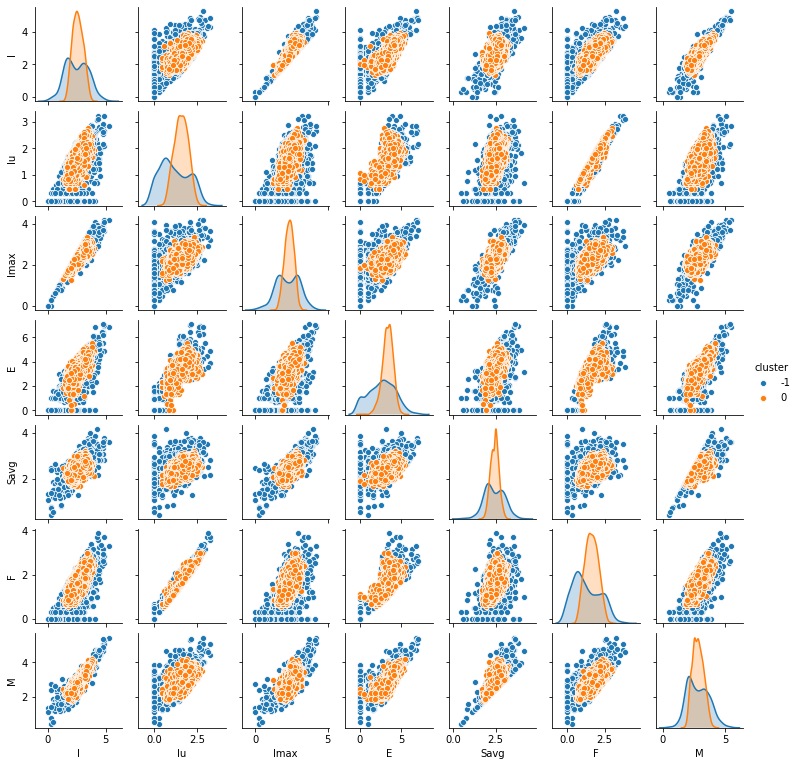

In [93]:
sns.pairplot(customer_profile_dbscan, hue='cluster', diag_kind='kde', height=1.5);

## Agglomerative Clustering

In [94]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

- *Ward* minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters
- *single* or *maximum linkage* uses the minimum of the distances between all observations of the two sets
    - strength: can handle non-elliptical shapes
    - limitations: sensitive to noise and outliers
- *complete* or *maximum linkage* uses the maximum distances between all observations of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: tends to break large clusters, biased towards globular clusters
- *average* linkage is a compromise between *single* and *complete* linkage by using the average of the distances of each observation of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters

### Ward Linkage

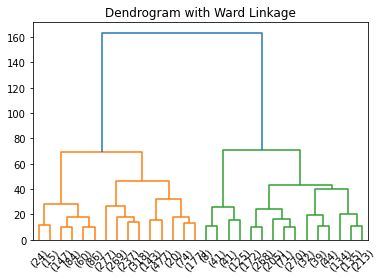

In [95]:
plt.title('Dendrogram with Ward Linkage')
ward_dendo = shc.dendrogram(shc.linkage(pca_customer_profile, method ='ward'), truncate_mode='lastp')

In [96]:
ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters_customers = ward.fit_predict(pca_customer_profile)

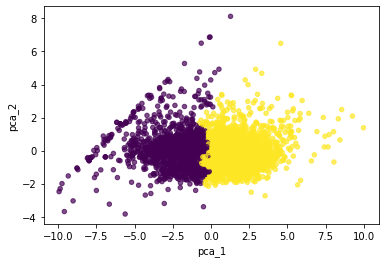

In [97]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [98]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0     1
CustomersNb  1798  2408

For comparison, if we run the agglomerative clustering algorithm with the Ward linkage without the PCA step, the result would be the following:

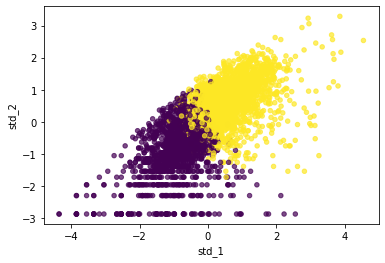

In [99]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [100]:
customer_profile_ward = customer_profile.copy(deep=True)
customer_profile_ward['cluster'] = clusters_customers
customer_profile_ward['cluster'] = customer_profile_ward['cluster']
customer_profile_ward

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M  cluster  
CustomerID                     
12347.0     3.556087        1  
12348.0     2.894560        1  
12349.0     3.163623        1  
12350.0     2.468938        0  
12352.0     3.102231        1  
...              ...      ...  
18280.0     2.256718        0  
18281.0     1.907519        0  
18282.0     2.246991        0  
18283.0     3.309541        1  
18287.0     3.264175        1  

[4206 rows x 8 columns]

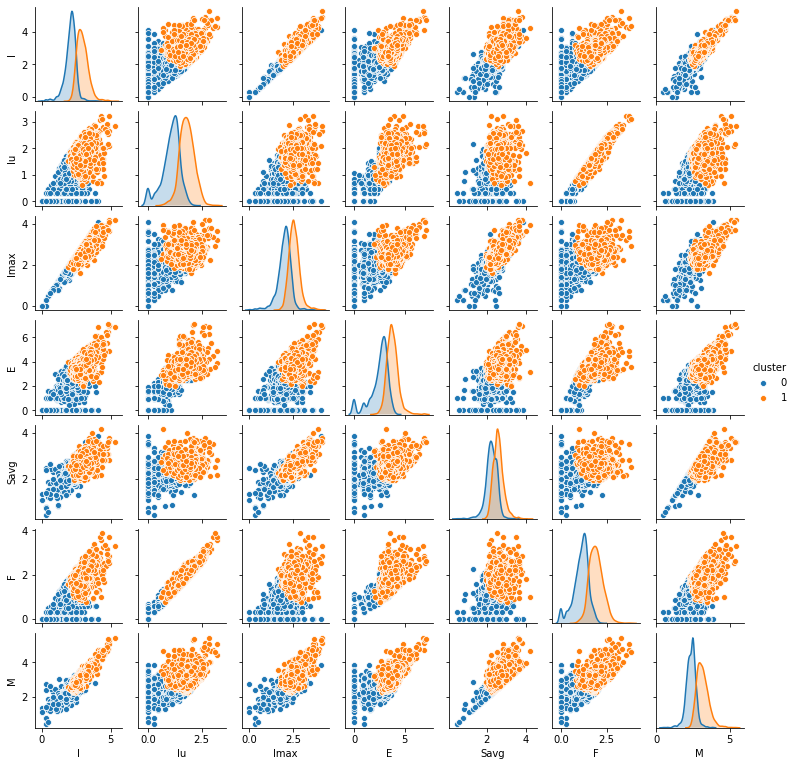

In [101]:
sns.pairplot(customer_profile_ward, hue='cluster', diag_kind='kde', height=1.5);

### Single Linkage

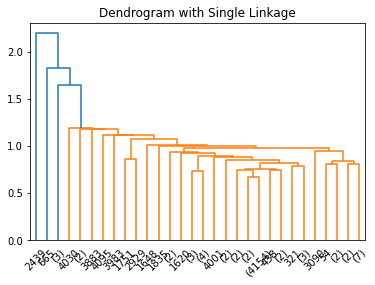

In [103]:
plt.title('Dendrogram with Single Linkage') 
min_dendo = shc.dendrogram(shc.linkage(pca_customer_profile, method ='single'), truncate_mode='lastp')

In [139]:
single = AgglomerativeClustering(n_clusters=2, linkage='single')
clusters_customers = single.fit_predict(pca_customer_profile)

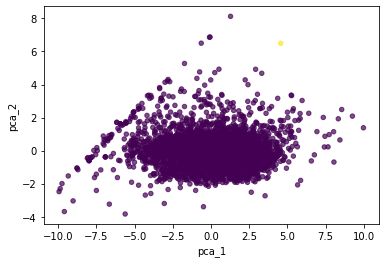

In [140]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [141]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0  1
CustomersNb  4205  1

For comparison, if we run the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

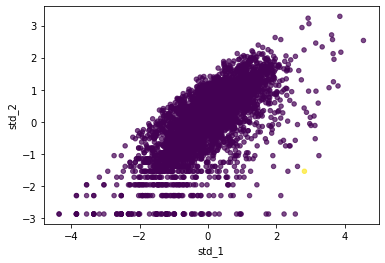

In [107]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [108]:
customer_profile_single = customer_profile.copy(deep=True)
customer_profile_single['cluster'] = clusters_customers
customer_profile_single['cluster'] = customer_profile_single['cluster']
customer_profile_single

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M  cluster  
CustomerID                     
12347.0     3.556087        0  
12348.0     2.894560        0  
12349.0     3.163623        0  
12350.0     2.468938        0  
12352.0     3.102231        0  
...              ...      ...  
18280.0     2.256718        0  
18281.0     1.907519        0  
18282.0     2.246991        0  
18283.0     3.309541        0  
18287.0     3.264175        0  

[4206 rows x 8 columns]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to c

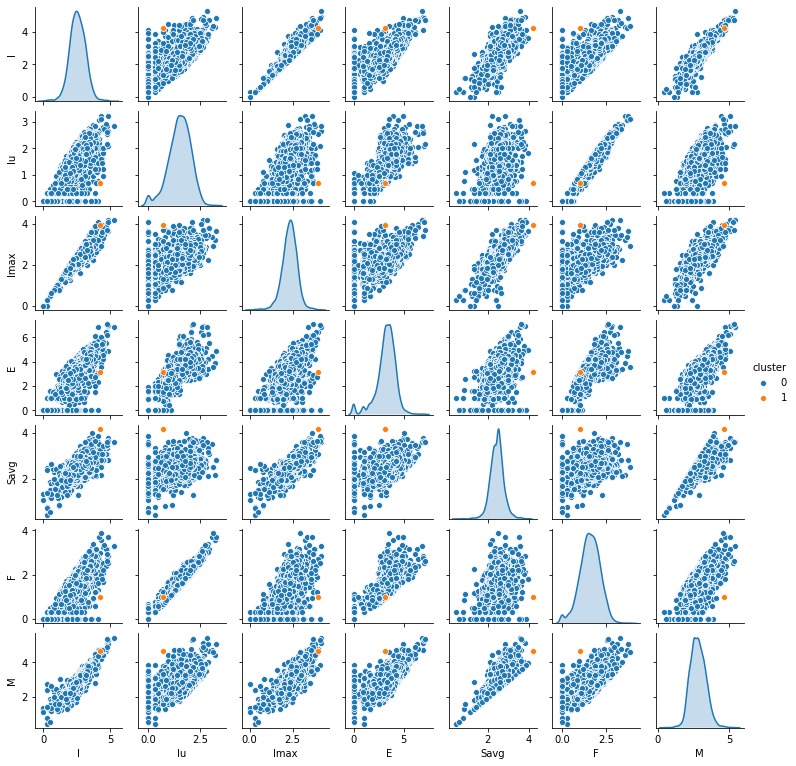

In [109]:
sns.pairplot(customer_profile_single, hue='cluster', diag_kind='kde', height=1.5);

### Complete Linkage

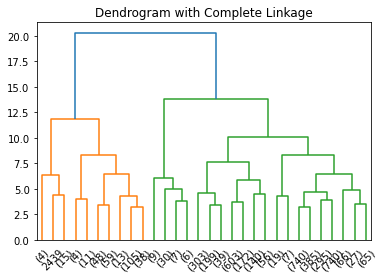

In [110]:
plt.title('Dendrogram with Complete Linkage') 
max_dendo = shc.dendrogram(shc.linkage(pca_customer_profile, method ='complete'), truncate_mode='lastp')

In [111]:
complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters_customers = complete.fit_predict(pca_customer_profile)

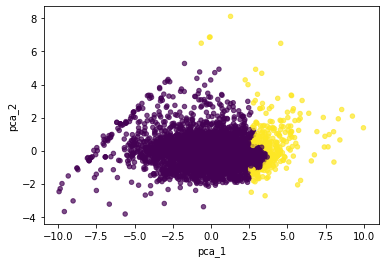

In [112]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [113]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0    1
CustomersNb  3908  298

For comparison, if we run the agglomerative clustering algorithm with the complete linkage without the PCA step, the result would be the following:

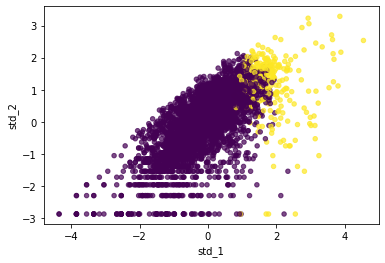

In [114]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [115]:
customer_profile_complete = customer_profile.copy(deep=True)
customer_profile_complete['cluster'] = clusters_customers
customer_profile_complete['cluster'] = customer_profile_complete['cluster']
customer_profile_complete

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M  cluster  
CustomerID                     
12347.0     3.556087        0  
12348.0     2.894560        0  
12349.0     3.163623        0  
12350.0     2.468938        0  
12352.0     3.102231        0  
...              ...      ...  
18280.0     2.256718        0  
18281.0     1.907519        0  
18282.0     2.246991        0  
18283.0     3.309541        0  
18287.0     3.264175        0  

[4206 rows x 8 columns]

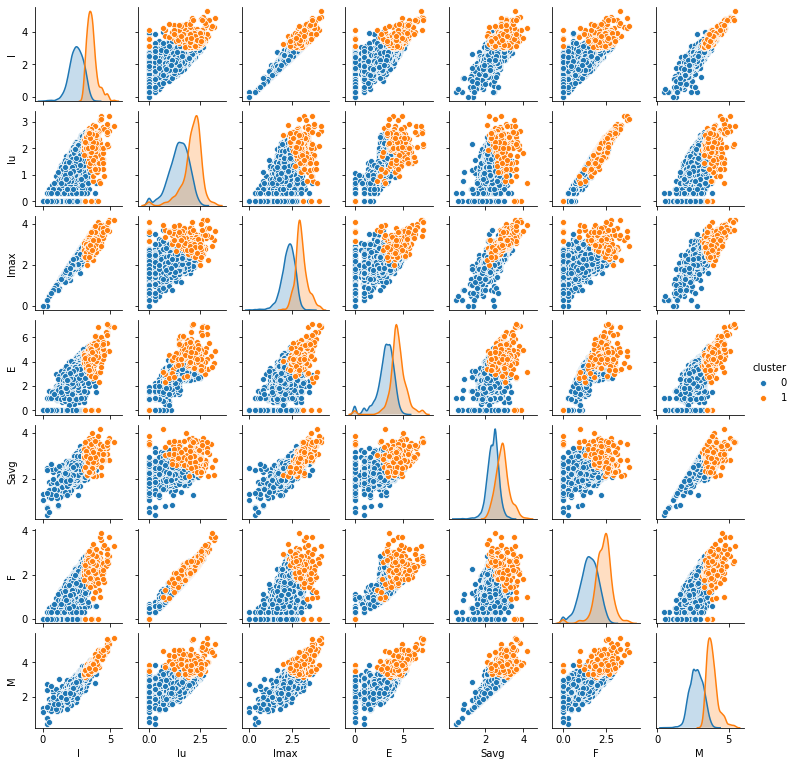

In [116]:
sns.pairplot(customer_profile_complete, hue='cluster', diag_kind='kde', height=1.5);

### Average Linkage

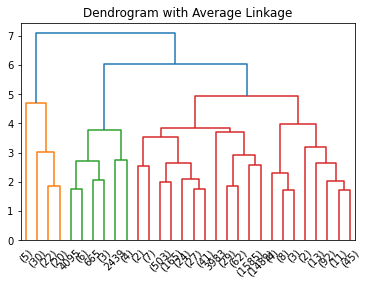

In [275]:
plt.title('Dendrogram with Average Linkage') 
avg_dendo = shc.dendrogram(shc.linkage(pca_customer_profile, method ='average'), truncate_mode='lastp')

In [276]:
avg = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters_customers = avg.fit_predict(pca_customer_profile)

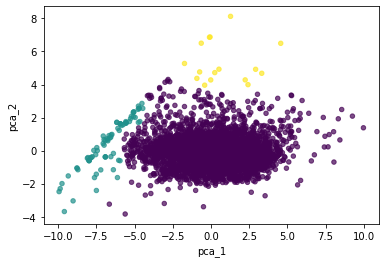

In [277]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [278]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0   1   2
CustomersNb  4113  77  16

For comparison, if we run the agglomerative clustering algorithm with the average linkage without the PCA step, the result would be the following:

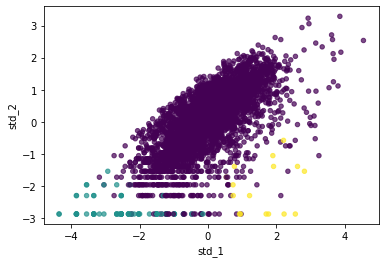

In [279]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [282]:
customer_profile_avg = customer_profile.copy(deep=True)
customer_profile_avg['cluster'] = clusters_customers
customer_profile_avg['cluster'] = customer_profile_avg['cluster'].map({0: 'medium', 1: 'low', 2: 'high'}) # check clusters-labels mapping for each run!
customer_profile_avg

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M cluster  
CustomerID                    
12347.0     3.556087  medium  
12348.0     2.894560  medium  
12349.0     3.163623  medium  
12350.0     2.468938  medium  
12352.0     3.102231  medium  
...              ...     ...  
18280.0     2.256718  medium  
18281.0     1.907519  medium  
18282.0     2.246991  medium  
18283.0     3.309541  medium  
18287.0     3.264175  medium  

[4206 rows x 8 columns]

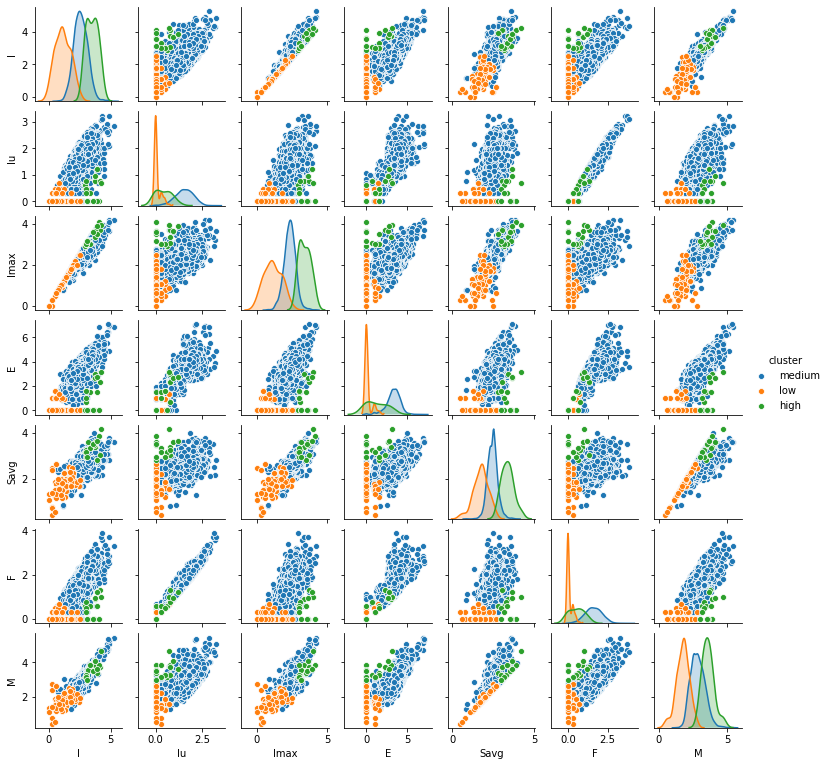

In [283]:
sns.pairplot(customer_profile_avg, hue='cluster', diag_kind='kde', height=1.5);

In [284]:
customer_profile_avg.to_csv('../dataset/customer_profile_avg.csv', sep='\t')

## Birch

In [285]:
from sklearn.cluster import Birch

In [286]:
birch = Birch(n_clusters=3)
clusters_customers = birch.fit_predict(pca_customer_profile)

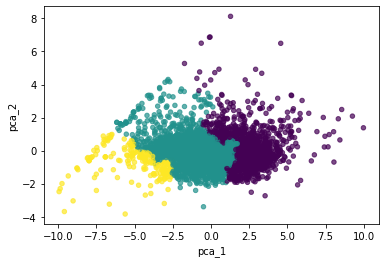

In [287]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

In [288]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

0     1    2
CustomersNb  1315  2703  188

For comparison, if we run the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

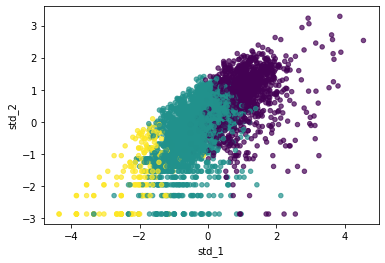

In [289]:
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [290]:
customer_profile_birch = customer_profile.copy(deep=True)
customer_profile_birch['cluster'] = clusters_customers
customer_profile_birch['cluster'] = customer_profile_birch['cluster'].map({0: 'high', 1: 'medium', 2: 'low'}) # check clusters-labels mapping for each run!
customer_profile_birch

I        Iu      Imax         E      Savg         F  \
CustomerID                                                               
12347.0     3.330211  1.939519  2.829947  4.239118  2.777935  2.178977   
12348.0     3.035029  0.954243  2.778151  2.550341  2.417438  1.041393   
12349.0     2.799341  1.857332  2.799341  3.903268  3.163623  1.857332   
12350.0     2.292256  1.204120  2.292256  2.500000  2.468938  1.204120   
12352.0     2.665581  1.755875  2.096910  3.158366  2.324080  1.845098   
...              ...       ...       ...       ...       ...       ...   
18280.0     1.653213  1.000000  1.653213  1.846439  2.256718  1.000000   
18281.0     1.732394  0.845098  1.732394  1.842371  1.907519  0.845098   
18282.0     1.991226  1.079181  1.845098  3.022055  1.945961  1.079181   
18283.0     3.131939  2.418301  2.382017  2.627193  2.105421  2.856729   
18287.0     3.200303  1.770852  2.995635  4.198218  2.787054  1.845098   

                   M cluster  
CustomerID                    
12347.0     3.556087    high  
12348.0     2.894560    high  
12349.0     3.163623    high  
12350.0     2.468938  medium  
12352.0     3.102231  medium  
...              ...     ...  
18280.0     2.256718  medium  
18281.0     1.907519     low  
18282.0     2.246991  medium  
18283.0     3.309541    high  
18287.0     3.264175    high  

[4206 rows x 8 columns]

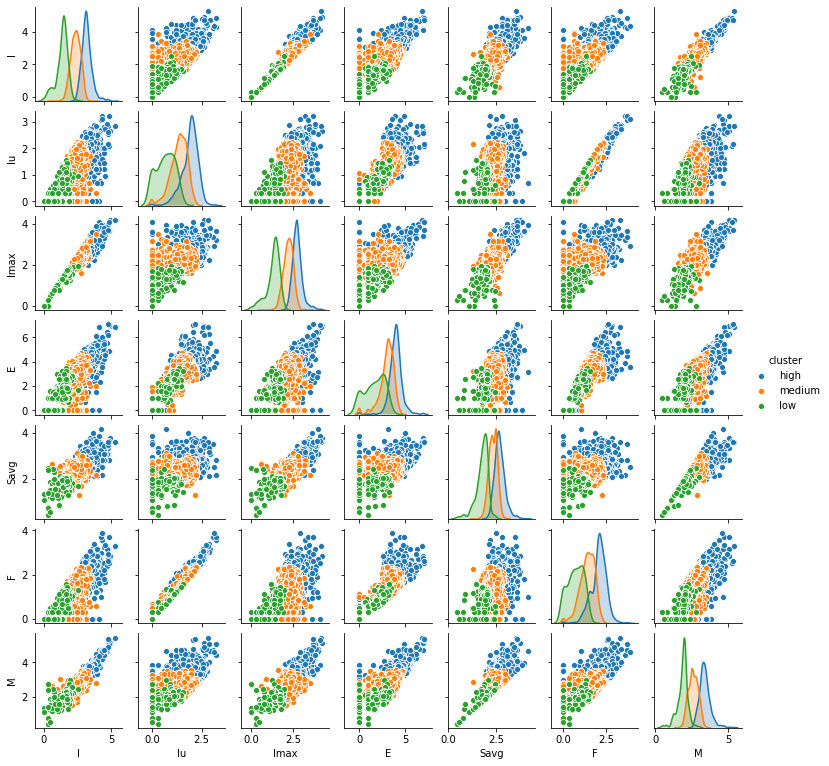

In [291]:
sns.pairplot(customer_profile_birch, hue='cluster', diag_kind='kde', height=1.5);

In [292]:
customer_profile_birch.to_csv('../dataset/customer_profile_birch.csv', sep='\t')